<a href="https://colab.research.google.com/github/premonish/YOUNGER_deprecated/blob/main/YOUNGER_Age_Estimator_040521_1531.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **I. PROBLEM IDENTIFICATION**

## A. Introduction


**[INPUT] → [OUTPUT]**

**[Photo of a face] → [Age estimate]**

**CONTEXT:** "Babyface" a startup skincare company wants to build an app that can estimate a person’s age from an image. They need an app to create an age estimate. The primary problem to solve is: When given a photo of a face, estimate the age with reasonable accuracy. Babyface will eventually use this to create "before & after" age estimates to demonstrate the benefit of their products.

## B. Proposed Method

**i. The techniques** to explore are a combination of **Support Vector Machines, Decision Trees, K Nearest Neighbor, and CNN** (for feature detection).

**ii. Pipeline**

1. DATA WRANGLING - Source Data, Download Data, Explore Data, Clean Data
2. EXPLORATORY DATA ANALYSIS - Statistical EDA, Visual EDA
3. PREPROCESSING - Face Detection, Crop Images, Augmentation
4. TRAINING - Feature Extraction
5. MODELING - Prediction, Hyperparameter Tuning

# **II. DATA WRANGLING**

**DATASET:** [IMDB-WIKI – 500k+ face images with age and gender labels
Rasmus Rothe, Radu Timofte, Luc Van Gool](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)
Researchers from ETH Zurich University have created a labeled dataset with success in predicting age and gender from face images.
An image dataset consists of human faces with ages. There are 99 folders where the name of each folder represents the age of the faces inside the folder.

"In total we obtained 460,723 face images from 20,284 celebrities from IMDb and 62,328 from Wikipedia, thus 523,051 in total."

**DETAILS:** The dataset that we will use for our age predictor was created by Rasmus Rothe, Radu Timofte, Luc Van Gool in combination with a competition "ChaLearn LAP 2015" dataset. This dataset was scraped from IMDb and Wikipedia. The dataset is labeled with date-of-birth (DOB) and gender and include only images with timestamps, indicating when the image was captured. The age of the person in the image can be obtained by simply subtracting the person's date of birth from the timestamp date. It is important to note that some of the IMDb dataset images are "production photos" like movie posters and the timestamps may not be precise, since movie production cycles can be months long.

**APPROACH:** *Download, Explore, Clean:* We will start by downloading the dataset and exploring the images and metadata to understand how to label the data properly with the ages of the subjects. We will then clean our dataset as needed. 

In [1]:
# !pip install tensorflow

In [2]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import requests
import scipy.io
from datetime import datetime, date, time, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input

In [3]:
# mount GDrive where the dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


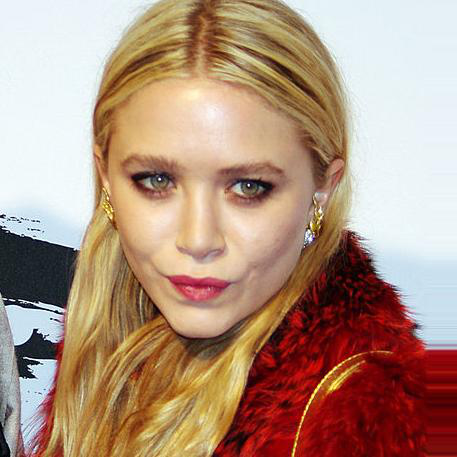

In [4]:
### VIEW AN IMAGE FROM DATASET ###
# loc = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop_subset/81800_1986-06-13_2011.jpg'
loc = '/content/drive/MyDrive/YOUNGER/wiki_crop_subset/81800_1986-06-13_2011.jpg'
image1 = Image.open(loc)
image1

In [5]:
### LOAD METADATA FILE ###
# wiki_mat_path = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/wiki.mat'
wiki_mat_path = '/content/drive/MyDrive/YOUNGER/wiki.mat' # COLAB

# load .mat as python dict
mat = scipy.io.loadmat(wiki_mat_path)

In [6]:
# Metadata Keys #
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wiki'])


**Metadata Features**

The metadata was in a MATLAB ".mat" format and has a deeply nested structure. We will dig into the layers of the file to pull out the data we need. Namely, we need: Date-of-Birth (dob), photo taken date, gender and path (file location). Additionally, there are some features that have been already created from pre-processing the dataset. Namely, these features are: face_location, face_score, and second_face_score. These engineered features were created with a face detection algorithm and contain the relative position of the face, how strongly a face was detected in the image and how strongly a second face was detected, respectively. 

In [7]:
### EXPLORE METADATA STRUCTURE ###
print(mat['wiki'][0][0])

(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
        array(['Dettmar Cramer'], dtype='<U14'),
        array(['Marc Okrand'], dtype='<U11'), ...,
        array(['Michael Wiesinger'], dtype='<U17'),
        array(['Johann Grugger'], dtype='<U14'),
        array(['Greta Van Susteren'], dtype='<U18')]], dtype=object), array([[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]]),
  

**Metadata Feature Descriptions**

---

**dob:** date of birth (Matlab serial date number)

**photo_taken:** year when the photo was taken

**full_path:** path to file

**gender:** 0 for female and 1 for male, NaN if unknown

**name:** full name 

***face_location:** location of the face 

***face_score:** detector score ('inf'= no face detected)

***second_face_score:** detector score of the face with the second highest score. (NaN if no second face was detected.)

---

(*)  Features created during preprocessing indicated with asterisk *

**MATLAB to pandas DataFrame**

Next, we will transform the data from the '.mat' MATLAB nested format into an easier to read pandas dataframe with a familiar table structure.

In [8]:
### CREATE DATAFRAME FROM METADATA ###

# Assign the length of the array to 'num_of_observations'
num_of_observations = mat['wiki'][0][0][0].shape[1]

# Create column names
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create pandas dataframe as tall as 'num_of_observations' with column headers from metadata
df = pd.DataFrame(index = range(0, num_of_observations), columns = columns)

# Iterate through the 'wiki' header of the metadata
for i in mat:
  if i == "wiki":
    wiki_array = mat[i][0][0] # Dig two layers into the dict structure and assign to 'wiki_array'
    for b in range(len(wiki_array)):  # Create a pandas dataframe for each nested value and assign to respective df[columns]
      df[columns[b]] = pd.DataFrame(wiki_array[b][0])

df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


In [9]:
### INSPECT DATAFRAME ###
print(df.info())
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB
None


(62328, 8)

In [10]:
print("General information about the dataset: ")
print("======================================")
print("Oldest Photo Date: "+str(df.photo_taken.min()))
print("Most Recent Photo Date: "+str(df.photo_taken.max()))
print("Minimum Face Score: "+str(df.face_score.min()))
print("Maximum Face Score: "+str(round(df.face_score.max(),3)))
print("Null Second Face Scores: "+ str(df.second_face_score.isna().sum()))

General information about the dataset: 
Oldest Photo Date: 1940
Most Recent Photo Date: 2015
Minimum Face Score: -inf
Maximum Face Score: 7.081
Null Second Face Scores: 58232


In [11]:
# Create function to convert Matlab datenum into Python datetime.
def datenum_to_datetime(datenum):
  days = datenum % 1
  hours = days % 1 * 24
  minutes = hours % 1 * 60
  seconds = minutes % 1 * 60
  exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
  return exact_date.year
 
# Convert Matlab datenum into Python datetime & create a new columns 'date_of_birth'
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

# Compute age by subtracting 'date_of_birth' from 'photo_taken'
df['age'] = df['photo_taken'] - df['date_of_birth']

In [12]:
df.shape

(62328, 10)

In [13]:
# value counts per column
# histograms for values of age
print('age.max', str(df.age.max()))
print('age.min', str(df.age.min()))

age.max 1996
age.min -74


In [14]:
df.second_face_score.value_counts()

1.287533    4
1.227850    3
2.712196    3
2.070053    3
2.285850    3
           ..
0.732939    1
3.531713    1
3.128854    1
2.010612    1
2.588861    1
Name: second_face_score, Length: 3888, dtype: int64

In [15]:
### CLEAN THE DATASET ###
# Remove images where faces are not detected
df = df[df['face_score'] != -np.inf]
 
# Include only images with a second face score missing
df = df[df['second_face_score'].isna()]
 
# Include images that have a primary 'face_score' of 3 or more
df = df[df['face_score'] >= 3]
 
# Remove records with missing gender data
df = df[~df['gender'].isna()]

# subset for genders
df_gender0 = df[df['gender'] == 0]
df_gender1 = df[df['gender'] == 1]
# print(gender0)

# Drop columns that won't inform the prediction model (name)
# df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])
df = df.drop(columns = ['name'])

In [16]:
### MORE CLEANING  ###
# Remove ages over 100 & remove ages under 0
df = df[df['age'] <= 100]
df = df[df['age'] > 0]

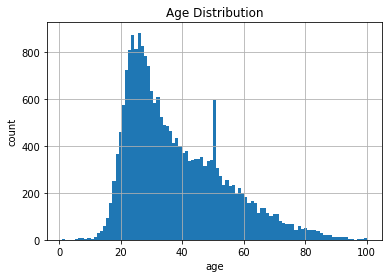

In [17]:
# Plot Age Distribution represented in the dataset
histogram_age = df['age'].hist(bins=df['age'].nunique())
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

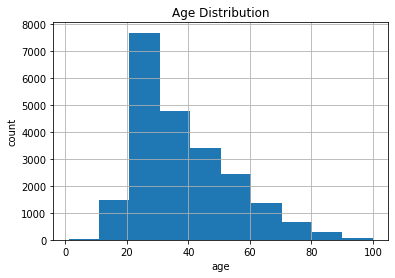

In [18]:
# Plot Age Distribution in ten (10) age bins
histogram_age = df['age'].hist(bins=10)
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

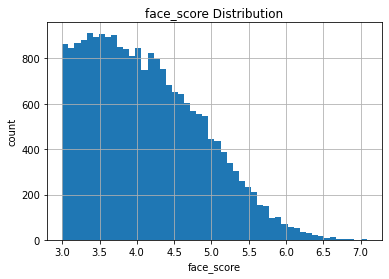

In [19]:
# Plot face_score Distribution represented in the dataset
histogram_age = df['face_score'].hist(bins=50)
plt.title('face_score Distribution')
plt.xlabel('face_score')
plt.ylabel('count');

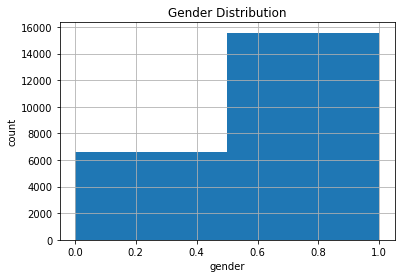

In [20]:
# Plot Gender Distribution represented in the dataset
histogram_age = df['gender'].hist(bins=2)
plt.title('Gender Distribution')
plt.xlabel('gender')
plt.ylabel('count');

In [21]:
df.shape

(22138, 9)

In [22]:
# METADATA Dataframe Info #
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 62327
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                22138 non-null  int32  
 1   photo_taken        22138 non-null  uint16 
 2   full_path          22138 non-null  object 
 3   gender             22138 non-null  float64
 4   face_location      22138 non-null  object 
 5   face_score         22138 non-null  float64
 6   second_face_score  0 non-null      float64
 7   date_of_birth      22138 non-null  int64  
 8   age                22138 non-null  int64  
dtypes: float64(3), int32(1), int64(2), object(2), uint16(1)
memory usage: 1.5+ MB


# **III. EXPLORATORY DATA ANALYSIS**

In [23]:
### Basic Statistical EDA on the Age Distribution ###
df.age.describe()

count    22138.000000
mean        38.210678
std         15.871291
min          1.000000
25%         26.000000
50%         34.000000
75%         48.000000
max        100.000000
Name: age, dtype: float64

***There seems to be an oddly overrepresented class around age 50. We will need to inspect further to figure out if this is a pre-processing issue that need to be fixed. ***

In [24]:
## Inspecting the odd value
hey = df.age.value_counts().sort_values(ascending=False)
#hey[:30]

In [25]:
df.head()

,dob,photo_taken,full_path,gender,face_location,face_score,second_face_score,date_of_birth,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,"[[274.76563240288175, 57.7700900839337, 376.88...",4.748056,NaN,1960,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,"[[79.35580188693945, 26.65993396231315, 197.60...",4.184828,NaN,1937,34


**Images ---> PIXEL values ---> Vectors**

We need to convert the images from pixels to vectors to prepare our images to hunt for features (patterns).

Each digital image is composed of a large grid of pixels. In color images, each pixel has 3 color channels: Red, Green, Blue (RGB). Each color channel's intensity are in the range [0-255]. 

To translate our images from photos (jpg format) to vectors of pixel values, we will first use a *Keras module called "load_img" to read the images in a PIL (Python Imaging Library) format. We will set the 'color mode' argument to (RGB) and set the target-size to 224 x 224 pixels. Next, we will use Kera's "img_to_array" module to extract the pixel information and store it in an array (index-based vector) of 150,528 numbers per image (224x224x3). 

'preprocess_input' = Preprocesses a tensor or Numpy array encoding a batch of images.

*Keras is a high-level API interface for TensorFlow for working with artificial neural networks (ANN). TensorFlow & Keras are frequently used on computer vision image classification projects, such as this. 


*Prem: I remember being inspired to learn about AI when hearing VC Marc Andreessen talk about how acccessible TensorFlow was in a 2018 Tim Ferriss Podcast. He said " So all of a sudden, AI is like a tractable thing that you can just have on your own laptop, and you can build new things on top of it. "*

In [26]:
# Create function to load images using 'load_img' and create 1 array per image (224,224,3)
# from tf.keras.applications import resnet 
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
target_size=(224, 224)

def getImagePixels(image_path):
    # img = image.load_img("C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/%s" % image_path[0], grayscale=False, target_size=(224, 224))
    img = image.load_img("/content/drive/MyDrive/YOUNGER/wiki_crop/%s" % image_path[0], color_mode='rgb', target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    # x = preprocess_input(x)
    return x

In [27]:
### SUBSETTING THE DATASET FOR RAPID TESTING #####################
### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### 
df = df[:4000]
### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### 
### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### 

In [28]:
%%time
# apply 'getImagePixels' function to all observations and create new column df.pixels
df['pixels'] = df['full_path'].apply(getImagePixels)

CPU times: user 8.09 s, sys: 2.16 s, total: 10.3 s
Wall time: 15 s


In [ ]:
"Average" Face Image

**"Average" Face Image**

It is interesting to think about an average face. What would that look like? Well, since we already have our face image dataset, we can aggregate the mean (average) of the arrays of each image and create "Average" face images with different subset sizes. Let's try this with 2, 5, 20, 100, and 1000 face images for fun.



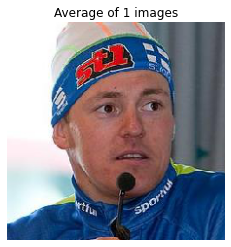

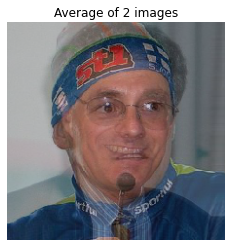

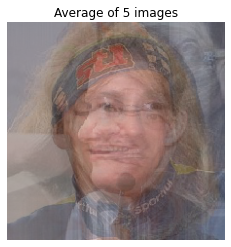

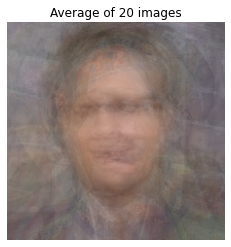

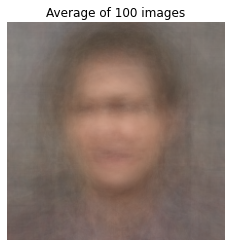

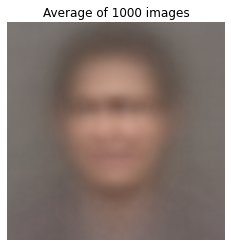

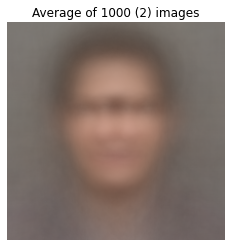

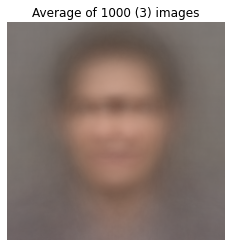

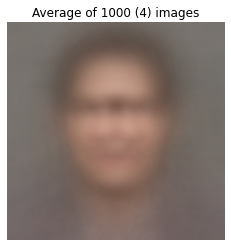

In [62]:
def find_mean_img(full_mat, title, size=(224,224,3)):
    # calculate the average
    mean_img = np.mean(full_mat, axis=0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    mean_img = mean_img/255
    plt.imshow(mean_img)
    plt.title(f'Average of {title} images')
    plt.axis('off')
    plt.show()
    return mean_img

all_mean = find_mean_img(df['pixels'][0:1], '1')
all_mean2 = find_mean_img(df['pixels'][:2], '2')
all_mean5 = find_mean_img(df['pixels'][:5], '5')
all_mean20 = find_mean_img(df['pixels'][:20], '20')
all_mean100 = find_mean_img(df['pixels'][:100], '100')
all_mean1000 = find_mean_img(df['pixels'][:1000], '1000')
all_mean2000 = find_mean_img(df['pixels'][1000:2000], '1000 (2)')
all_mean3000 = find_mean_img(df['pixels'][2000:3000], '1000 (3)')
all_mean4000 = find_mean_img(df['pixels'][3000:4000], '1000 (4)')

**Average Face Comment**

The last four (4) composite images appear to be very similar. Each composite image is the average of a *distinct* subset of the dataset. The images seem to converge into a regular average 'face' with a distinguishable head shape, a horizontal darker band where eyes would be and some vague nose and mouth features. It is important to note that the preprocessed dataset have been cropped to align faces in the center with approximately the same space around the head.


In [30]:
# spot check the 'apply' application of the function #
df['pixels'][:5]

0    [255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...
2    [92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96....
4    [61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30....
5    [97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,...
6    [190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203...
Name: pixels, dtype: object

In [31]:
# Export a '.csv' file of the dataframe
# This is a sensible place to pick up the project from for the next phases. 
# Applying the 'getImagePixels' function is time-consuming task and we don't want to run it again.
# df.to_csv('out22000.csv', index=False)

In [32]:
## Created the dataframe in stages as the 'getImagePixels' function was overwhelming the RAM when run for 22,000 records ##
# one = pd.read_csv('/content/out10000.csv')
# two = pd.read_csv('/content/out20000.csv')
# three = pd.read_csv('/content/out22000.csv')
# df2 = one.append(two, ignore_index=True)
# df3 = df2.append(three, ignore_index=True)
# df3.shape
# df3.to_csv('out_all.csv', index=False)

In [33]:
# df = pd.read_csv('/content/drive/MyDrive/YOUNGER/out.csv', index_col=False)
# type(df.pixels)

In [34]:
## LOAD processed csv as a pandas DataFrame ##
# df = pd.read_csv('/content/out_all.csv')
# df.shape

In [35]:
### Are there null values in the pixel column? ###
print("There are "+ str(df.pixels.isnull().sum())+ " null values in the pixels column")

There are 0 null values in the pixels column


# **IV. PREPROCESSING AND TRAINING**


In [36]:
classes = 101 #0 to 100
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)
 
features = []
 
for i in range(0, df.shape[0]):
  features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)
features /= 255 #normalize in [0, 1]
features.shape

(4000, 224, 224, 3)

In [37]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30, random_state=42)

# **V. MODELING**

In [38]:
# %load vgg-face.py
# Tensorflow version == 2.0.0
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K

from keras.models import model_from_json

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [39]:
# Load VGG Face model weights
# 'vgg_face_weights.h5'
vgg_path = '/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5' #COLAB
model.load_weights(vgg_path)

In [40]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [41]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [42]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  # , optimizer = sgd
                  , metrics=['accuracy']
                 )

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint
age_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
 
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/YOUNGER/age_model.hdf5", 
                               monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')

scores = []

In [44]:
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    # restore the best weights
    from keras.models import load_model
    age_model = load_model("/content/drive/MyDrive/YOUNGER/age_model.hdf5")
    
    age_model.save_weights('age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights.h5")

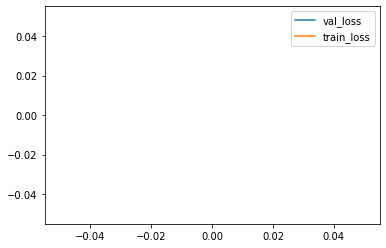

In [45]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [46]:
age_model.evaluate(test_x, test_y, verbose=1)

38/38 [==============================] - 39s 155ms/step - loss: 3.3404 - accuracy: 0.0585


[3.2872977256774902, 0.06583333015441895]

In [47]:
predictions = age_model.predict(test_x)

In [48]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [49]:
mae = 0
 
for i in range(0 ,apparent_predictions.shape[0]):
  prediction = int(apparent_predictions[i])
  actual = np.argmax(test_y[i])
 
  abs_error = abs(prediction - actual)
  # actual_mean = actual_mean + actual
 
  mae = mae + abs_error
 
mae = mae / apparent_predictions.shape[0]
 
print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  5.1325
instances:  1200


In [50]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(224, 224))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img                       
 
picture = '/content/drive/MyDrive/YOUNGER/pinky_linkedIn.jpg'

prediction = age_model.predict(loadImage(picture))

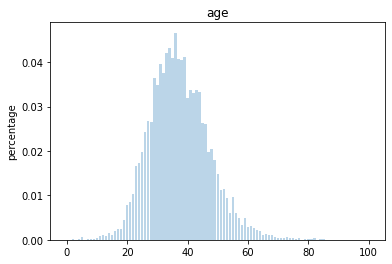

In [51]:
y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

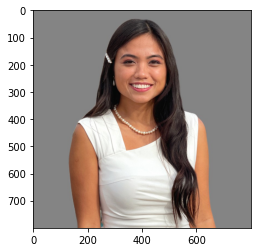

most dominant age class (not apparent age):  36
apparent age:  37


In [52]:
# picture = '/content/drive/MyDrive/YOUNGER/klee kai.jpg'
img = image.load_img(picture) #, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))

apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

# **VI. DOCUMENTATION**

# **VII. PRESENTATION**

# **VIII. REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 



---


@article{Rothe-IJCV-2018,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision},
  volume={126},
  number={2-4},
  pages={144--157},
  year={2018},
  publisher={Springer}
}

@InProceedings{Rothe-ICCVW-2015,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {DEX: Deep EXpectation of apparent age from a single image},
  booktitle = {IEEE International Conference on Computer Vision Workshops (ICCVW)},
  year = {2015},
  month = {December},
}
